* [Lazyprogrammer: CNN TF](https://github.com/lazyprogrammer/machine_learning_examples/blob/master/cnn_class/cnn_tf.py)

* [LeCun 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

Downsampling -> After we do the convolution, was there a feature present in a certain area of the image?
`tf.nn.max_pool`

Take image `->` convolution + max_pool: reduce size of features `->` convolution + max_pool `->` flatten features into vector for input into a fully connected NN

Input image (N, C, W, H) + Convolution -> (N, C', W, H)
Filter (Num of feature maps in, num feature maps out, filter width, filter height)
 At the beginning the number of feature maps is 3 (3 colors going in).
Pooling: split up the original image into a grid of blocks each of size n x n

Image batch (15, 3, 32, 32) after a filter (3, 10, 5, 5) -> data (15, 10, 32, 32)
After a pooling operation with poolsize (2, 2) -> data (15,10, 16, 16)
After a convpool layer (, 8, 3, 3) with poolsize (2, 2) -> data (15, 8, 8, 8)
After Flatten -> Data (15, 8*8*8) = (15, 512)
With one feedforward layer with 100 hidden units, the size of the weight matrix at this layer has to be (512, 100)

* Input: 4-D tensor (N, 3 colors, width, height)
* Convolution filter (Kernel): 4-D tensor (feature maps, 3 colors, width, height) <br/>
 Each kernel extracts a different feature and places it on a feature map
 
 Each individual filter has the same dimensionality as the image!

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.signal import convolve2d
from sklearn.utils import shuffle

import tensorflow as tf

In [3]:
def y2indicator(Y, K=10):
    N = len(Y)
    indicator = np.zeros((N, K))
    for i in range(N):
        indicator[i, Y[i]] = 1
    return indicator

def error(p, t):
    return np.mean(p!=t)

In [9]:
def convpool(X, W, b):
    # strides - move with any step size
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.relu(pool_out)

def init_filter(shape, poolsz):
    # denominator ~ W*H*maps_in + maps_out*W*H/poolsize*poolsize
    denominator = np.prod(shape[:-1]) + shape[-1] * np.prod( shape[:-2]/np.prod(poolsz) )
    w = np.random.randn(*shape) / np.sqrt( denominator )
    return w.astype(np.float32)

def rearrange(X):
    # input is (32, 32, 3, N)
    # output is (N, 32, 32, 3)
    N = X.shape[-1]
    out = np.zeros((N, 32, 32, 3), dtype=np.float32)
    for i in range(N):
        for j in range(3):
            out[i, :, :, j] = X[:, :, j, i]
    return out / 255

In [13]:
train = loadmat('../datasets/svhn/format2/train_32x32.mat') # N = 73257
test = loadmat('../datasets/svhn/format2/test_32x32.mat')   # N = 26032

# We need to rearange the matlab files for our purposes
# Y will be an N X 1 matrix 1,...,10 (matlab)
Xtrain = rearrange(train['X'])
Ytrain = train['y'].flatten() - 1
del train

Xtest = rearrange(test['X'])
Ytest = test['y'].flatten() - 1
del test

In [22]:
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

# limit samples since input will always have to be same size
# you could also just do N = N / batch_sz * batch_sz
Xtrain = Xtrain[:73000//10,]
Ytrain = Ytrain[:73000//10]
Xtest = Xtest[:26000//10,]
Ytest = Ytest[:26000//10]
Ytest_ind = Ytest_ind[:26000//10,]

max_iter = 60
print_period = 10
N = Xtrain.shape[0] 
batch_size = 500
n_bathces = N//batch_size
K = len(set(Ytrain))
assert K==10
M = 500
poolsz = (2, 2)

# Weights
W1_shape = (5, 5, 3, 20) # filter width, filter height, num color channels, num feature maps
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[-1], dtype=np.float32) # 1 bias per output feature map

W2_shape = (5, 5, 20, 50) # filter width, filter height, old num feature maps, num feature maps
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[-1], dtype=np.float32)

W3_init = np.random.rand(W2_shape[-1]*8*8, M) / np.sqrt(W2_shape[-1]*8*8+M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M+K)
b4_init = np.zeros(K, dtype=np.float32)

# variables and expressions
# using None as the first shape element takes up too much RAM 
X = tf.placeholder(tf.float32, shape=(batch_size, 32, 32, 3), name='X')
T = tf.placeholder(tf.float32, shape=(batch_size, K), name='T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z2_shape = Z2.get_shape().as_list()
Z2r = tf.reshape(Z2, [Z2_shape[0], np.prod(Z2_shape[1:])])
Z3 = tf.nn.relu( tf.matmul(Z2r, W3)+b3 )
Yish = tf.matmul(Z3, W4)+b4

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=Yish, labels=T))
train_op = tf.train.RMSPropOptimizer(1.0e-4, decay=0.99, momentum=0.9).minimize(cost)
predict_op = tf.argmax(Yish, 1)

In [23]:
LL = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    
    for i in range(max_iter):
        for j in range(n_bathces):
            Xbatch = Xtrain[j*batch_size:(j+1)*batch_size, ]
            Ybatch = Ytrain_ind[j*batch_size:(j+1)*batch_size, ]
            
            if len(Xbatch)==batch_size:
                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                
        if i%print_period==0:
            # due to RAM limitations we need to have a fixed size input
            # so as a result, we have this ugly total cost and prediction computation
            test_cost = 0
            prediction = np.zeros(len(Xtest))
            for k in range(len(Xtest)//batch_size):
                Xtestbatch = Xtest[k*batch_size:(k+1)*batch_size, ]
                Ytestbatch = Ytest_ind[k*batch_size:(k+1)*batch_size, ]
                test_cost += session.run(cost, feed_dict={X: Xtestbatch, T: Ytestbatch})
                prediction[k*batch_size:(k+1)*batch_size] = session.run(predict_op, feed_dict={X: Xtestbatch})
            err = error(prediction, Ytest)
            print('Cost: {:.3f}, error: {:.3f}'.format(test_cost, err))
            LL.append(test_cost)

Cost: 5686.654, error: 0.843
Cost: 4803.874, error: 0.660
Cost: 2904.971, error: 0.372
Cost: 2502.600, error: 0.299
Cost: 2415.173, error: 0.291
Cost: 2346.598, error: 0.266


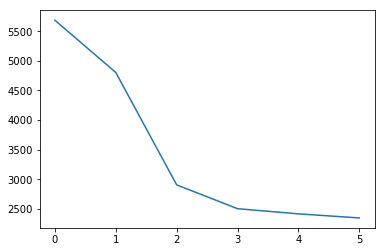

In [24]:
plt.plot(LL)
plt.show()